In [2]:
!pip install wordcloud
!pip install gensim
!pip install spacy
!pip install xgboost

In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Análise de Currículos



In [4]:
### Processamento de Dados ###
import numpy as np  # linear algebra
import pandas as pd

### Visualização de Dados ###
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

### Processamento de Texto ###
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
nlp = spacy.load("en_core_web_sm")
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re

### Machine Learning ###
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from xgboost import XGBClassifier


[nltk_data] Downloading package punkt to /home/gabiiwa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gabiiwa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/gabiiwa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Currículos do projeto ["Resume Dataset"](https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset/data)


In [5]:
df_resume = pd.read_csv('../dados/Resume/Resume.csv')
df_resume.rename(columns={"Resume_str":"Resume"},inplace=True,errors='ignore')
display(df_resume.head())
display(f"Quantas entradas:{df_resume.shape[0]}")

,ID,Resume,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


'Quantas entradas:2484'

In [6]:
# drop colunas que não estão sendo usadas
df_resume.drop(columns = ['ID', 'Resume_html'], inplace = True,errors='ignore')

In [7]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

## Currículos do projeto ["Updated Resume Dataset"](https://www.kaggle.com/datasets/jillanisofttech/updated-resume-dataset/data)


In [8]:
df_update = pd.read_csv("../dados/update_resume/UpdatedResumeDataSet.csv")

display(df_update.head())
display(f"Quantas entradas:{df_update.shape[0]}")

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


'Quantas entradas:962'

In [9]:
df_update.Category.unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [10]:
df_update["Category"] = df_update.Category.str.upper()
df_update

,Category,Resume
0,DATA SCIENCE,Skills * Programming Languages: Python (pandas...
1,DATA SCIENCE,Education Details \r\nMay 2013 to May 2017 B.E...
2,DATA SCIENCE,"Areas of Interest Deep Learning, Control Syste..."
3,DATA SCIENCE,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,DATA SCIENCE,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,TESTING,Computer Skills: â¢ Proficient in MS office (...
958,TESTING,â Willingness to accept the challenges. â ...
959,TESTING,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,TESTING,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


## Definindo Cenários para os testes
Neste etapa serão feitos os testes em dois datasets: um com o df_resume que foram os dados usados no teste do artigo e outro dataframe com os dados do artigo e os novos dados(update)

In [11]:
df_curr = pd.concat([df_resume,df_update],ignore_index=True)
df_curr

,Resume,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR
...,...,...
3441,Computer Skills: â¢ Proficient in MS office (...,TESTING
3442,â Willingness to accept the challenges. â ...,TESTING
3443,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",TESTING
3444,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,TESTING


In [12]:
df_curr.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION',
       'DATA SCIENCE', 'WEB DESIGNING', 'MECHANICAL ENGINEER',
       'HEALTH AND FITNESS', 'CIVIL ENGINEER', 'JAVA DEVELOPER',
       'BUSINESS ANALYST', 'SAP DEVELOPER', 'AUTOMATION TESTING',
       'ELECTRICAL ENGINEERING', 'OPERATIONS MANAGER', 'PYTHON DEVELOPER',
       'DEVOPS ENGINEER', 'NETWORK SECURITY ENGINEER', 'PMO', 'DATABASE',
       'HADOOP', 'ETL DEVELOPER', 'DOTNET DEVELOPER', 'BLOCKCHAIN',
       'TESTING'], dtype=object)

In [13]:
display(df_curr.describe())
print(f'Valores nulos? {True if sum(df_curr.isna().any())>0 else False}')
# print(f'Valores duplicados? {True if df_curr.duplicated().sum()>0 else False}')

,Resume,Category
count,3446,3446
unique,2648,45
top,"Technical Skills Web Technologies: Angular JS,...",SALES
freq,18,156


Valores nulos? False


In [14]:
df_curr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446 entries, 0 to 3445
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Resume    3446 non-null   object
 1   Category  3446 non-null   object
dtypes: object(2)
memory usage: 54.0+ KB


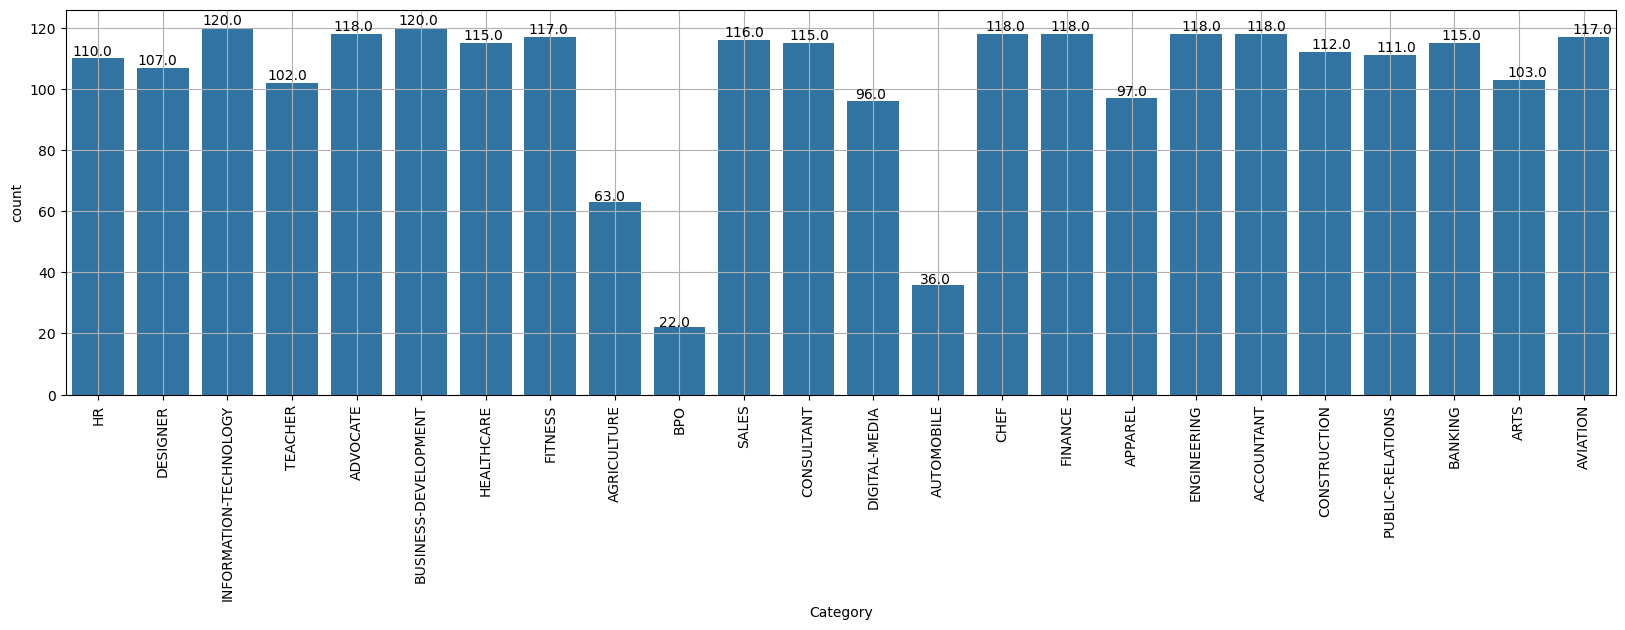

In [15]:
#### Dataframe com as catogerias do artigo ######
# Plotando histogramas de quantidade de curriculos por categoria
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax=sns.countplot(x="Category", data=df_resume)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.grid()

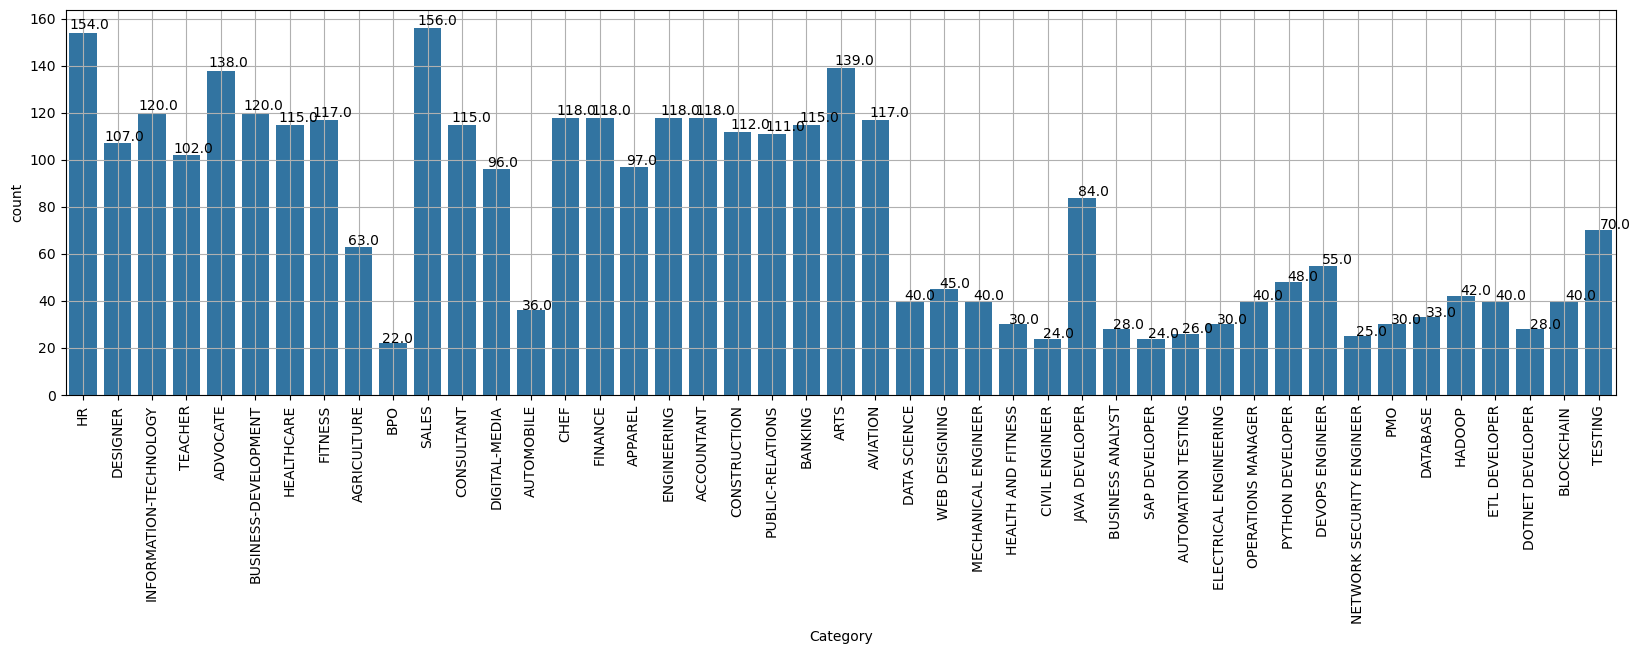

In [16]:
#### Dataframe com todas as catorias ######
# Plotando histogramas de quantidade de curriculos por categoria
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
ax=sns.countplot(x="Category", data=df_curr)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))
plt.grid()

## Pré-processamento
* Limpar o texto removendo caracteres especiais, pontuações e espaços extras.
* Converter o texto para maiúscula para padronização.
* Remover stop words (palavras comuns que não contribuem para a análise).
* Tokenizar usando o nltk


In [17]:
# Stemming e Lemmatization
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def stem_words(tokens):
    return [stemmer.stem(word) for word in tokens]

def lemmatize_words(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]


In [18]:
def preprocess(txt):
    # convertendo o texto para maiuscula
    txt = txt.lower()
    # removendo caracteres especiais, espaços extras, pontuações e números
    txt = re.sub('[^a-zA-Z]', ' ', txt)
    txt = re.sub('http\S+\s*', ' ', txt)  # removendo URLs
    txt = re.sub('RT|cc', ' ', txt)  # removendo informações desnecessárias
    txt = re.sub('#\S+', '', txt)  # removendo hashtags
    txt = re.sub('@\S+', '  ', txt)  # removendo menções
    txt = re.sub('\s+', ' ', txt)  # removendo espaçoes extras
    # tokenize
    txt = nltk.tokenize.word_tokenize(txt)
    # removendo stop words
    txt = [w for w in txt if not w in nltk.corpus.stopwords.words('english')]

    txt = stem_words(txt)
    txt = lemmatize_words(txt)
    return ' '.join(txt)

In [19]:
# limpando a coluna de curriculos de valores não conhecidos
df_resume["resume_cleaned"] = df_resume["Resume"].apply(lambda x:preprocess(x))
df_curr["resume_cleaned"] = df_curr["Resume"].apply(lambda x:preprocess(x))

In [20]:
display(df_curr)
display(df_resume)

,Resume,Category,resume_cleaned
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administr market associ hr administr summar...
1,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist u hr oper summari versatil mediu...
2,HR DIRECTOR Summary Over 2...,HR,hr director summari over year experi in recrui...
3,HR SPECIALIST Summary Dedica...,HR,hr specialist summari dedic driven and dynam w...
4,HR MANAGER Skill Highlights ...,HR,hr manag skill highlight hr skill hr depa ment...
...,...,...,...
3441,Computer Skills: â¢ Proficient in MS office (...,TESTING,comput skill profici in m offic word basic exc...
3442,â Willingness to accept the challenges. â ...,TESTING,willing to accept the challeng posit think goo...
3443,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",TESTING,person skill quick learner eager to learn new ...
3444,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,TESTING,comput skill softwar knowledg m power point m ...


,Resume,Category,resume_cleaned
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administr market associ hr administr summar...
1,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist u hr oper summari versatil mediu...
2,HR DIRECTOR Summary Over 2...,HR,hr director summari over year experi in recrui...
3,HR SPECIALIST Summary Dedica...,HR,hr specialist summari dedic driven and dynam w...
4,HR MANAGER Skill Highlights ...,HR,hr manag skill highlight hr skill hr depa ment...
...,...,...,...
2479,RANK: SGT/E-5 NON- COMMISSIONED OFFIC...,AVIATION,rank sgt e non commiss offic in charg brigad m...
2480,"GOVERNMENT RELATIONS, COMMUNICATIONS ...",AVIATION,govern relat commun and organiz develop direct...
2481,GEEK SQUAD AGENT Professional...,AVIATION,geek squad agent profession profil it suppo sp...
2482,PROGRAM DIRECTOR / OFFICE MANAGER ...,AVIATION,program director offic manag summari highli pe...


In [21]:
df_curr.to_csv("resume_todos_tokenizado.csv",sep=';')
df_resume.to_csv("resume_artigo_tokenizado.csv",sep=';')

## Reconhecimento de Entidades Nomeadas (NER)

In [22]:
# Função para extração de entidades
def extract_entities(text):
    doc = nlp(text)
    entities = [(entity.text, entity.label_) for entity in doc.ents]
    return entities

In [23]:
df_resume['entities'] = df_resume['resume_cleaned'].apply(extract_entities)
df_resume[['resume_cleaned', 'entities']].head()

,resume_cleaned,entities
0,hr administr market associ hr administr summar...,"[(associ, PERSON), (administr summari dedic cu..."
1,hr specialist u hr oper summari versatil mediu...,"[(manag commun, PERSON), (polici chang, PERSON..."
2,hr director summari over year experi in recrui...,"[(summari, PERSON), (over year, DATE), (plu ye..."
3,hr specialist summari dedic driven and dynam w...,"[(summari dedic, PERSON), (ise motiv, PERSON),..."
4,hr manag skill highlight hr skill hr depa ment...,"[(hr manag skill highlight, PERSON), (three, C..."


In [24]:
df_curr['entities'] = df_curr['resume_cleaned'].apply(extract_entities)
df_curr[['resume_cleaned', 'entities']].head()

,resume_cleaned,entities
0,hr administr market associ hr administr summar...,"[(associ, PERSON), (administr summari dedic cu..."
1,hr specialist u hr oper summari versatil mediu...,"[(manag commun, PERSON), (polici chang, PERSON..."
2,hr director summari over year experi in recrui...,"[(summari, PERSON), (over year, DATE), (plu ye..."
3,hr specialist summari dedic driven and dynam w...,"[(summari dedic, PERSON), (ise motiv, PERSON),..."
4,hr manag skill highlight hr skill hr depa ment...,"[(hr manag skill highlight, PERSON), (three, C..."


In [25]:
df_resume.to_csv("artigo_ner.csv",";")
df_curr.to_csv("todos_ner.csv",";")

## TF-IDF


In [29]:
#### Curriculos usados no Artigo ####
# Função para extrair apenas o texto das entidades 
def extract_entity_text(entities):
    return ' '.join([entity[0] for entity in entities])

# Extrair textos das entidades
df_resume['entities_text'] = df_resume['entities'].apply(extract_entity_text)

# Inicializar o vetor TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # max_features pode ser ajustado conforme necessário

# Ajustar e transformar os dados
X = vectorizer.fit_transform(df_resume['entities_text'])

# Converter para DataFrame
tfidf_df_resume = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Exibir as primeiras linhas
tfidf_df_resume.head()

,abc,abil,about,abov,abus,academ,access,accommod,account,accuraci,...,winter,wisconsin,work,workflow,workplac,xerox,year,york,zero,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.176643,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.104373,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.032337,0.0,0.0,0.0


In [28]:
#### Curriculos Update ####
# Extrair textos das entidades
df_curr['entities_text'] = df_curr['entities'].apply(extract_entity_text)

# Inicializar o vetor TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # max_features pode ser ajustado conforme necessário

# Ajustar e transformar os dados
X = vectorizer.fit_transform(df_curr['entities_text'])

# Converter para DataFrame
tfidf_df_curr = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Exibir as primeiras linhas
tfidf_df_curr.head()

,abc,abil,about,abov,abus,academ,access,accommod,account,accuraci,...,workflow,workplac,xen,xerox,xml,year,ymca,york,zero,zumba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.176443,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.1055,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.033325,0.0,0.0,0.0,0.0


## Classificação e Modelagem


In [35]:
class Model_Classification:
    def __init__(self, df, variables, target,targets_class_origin):
        self.variable = variables
        self.target = target
        self.df = df[variables + [target]]
        self.df_train, self.df_validation = train_test_split(self.df, test_size=0.2, random_state=42)
        self.best_params = None
        self.best_f1 = float('inf')
        self.final_model = None
        self.grid = None
        self.class_oigin=targets_class_origin

    def evaluation_metrics(self, y_true, y_pred):
        """ Calculate and return model evaluation metrics """
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        rec = recall_score(y_true, y_pred, average='macro')
        prec = precision_score(y_true, y_pred, average='macro')
        return {'accuracy': acc, 'f1_score': f1, 'recall': rec, 'precision': prec}
    
    def building_best_model(self, model, param_dist, n_iter, cv):
        """ Train and find the best model with Randomized and Grid Search CV """
        # Setting up RandomizedSearchCV
        random_search = RandomizedSearchCV(model, param_distributions=param_dist, 
                                           n_iter=n_iter, cv=cv, scoring='f1_macro', 
                                           verbose=1, random_state=42, n_jobs=-1)
        random_search.fit(self.df_train[self.variable], self.df_train[self.target])

        # Using the best parameters from RandomizedSearch to inform Grid Search
        best_params = {k: [v] for k, v in random_search.best_params_.items()}  # Ensure all values are lists
        grid_search = GridSearchCV(model, param_grid=best_params, 
                                   cv=cv, scoring='f1_macro', verbose=2, n_jobs=-1)
        grid_search.fit(self.df_train[self.variable], self.df_train[self.target])
        
        self.grid = grid_search
        self.best_params = grid_search.best_params_
        self.final_model = grid_search.best_estimator_
        self.best_f1 = grid_search.best_score_
        
    def plot_confusion_matrix(self):
        """Plot the confusion matrix of the validation set predictions."""
        if self.final_model is None or self.df_validation.empty:
            print("Model not trained or validation data not available.")
            return

        # Generate predictions
        y_true = self.df_validation[self.target]
        y_pred = self.predict(self.df_validation)

        # Compute the confusion matrix
        cm = confusion_matrix(y_true, y_pred, normalize='true')  # normalize to show percentages

        # Get class labels
        class_labels = {num:value for num,value in enumerate(self.class_oigin,start=1)}

        # Plotting the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
        plt.title('Confusion Matrix with Percentages')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
        
    def predict(self, new_data):
        """Make predictions with the final model on new data."""
        if self.final_model is None:
            print("Final model is not trained. Please run train_final_model first.")
            return
        return self.final_model.predict(new_data[self.variable])

#### Cenário com dados do Artigo Base

In [36]:
# Definindo as variáveis independentes (X) e a variável dependente (y)
variables = tfidf_df_resume.columns.tolist()  # As colunas TF-IDF como variáveis
target = 'Category'  # Substitua pelo nome real da coluna de rótulos

# Adicionando a coluna de rótulo ao DataFrame tfidf_df
tfidf_df_resume[target] = df_resume[target].replace({value:num for num,value in enumerate(df_resume[target].unique(),start=1)})

# Inicializar a classe de classificação
model_classification = Model_Classification(tfidf_df_resume, variables, target,df_resume[target].unique())

In [37]:
tfidf_df_resume.keys()

Index(['abc', 'abil', 'about', 'abov', 'abus', 'academ', 'access', 'accommod',
       'account', 'accuraci',
       ...
       'wisconsin', 'work', 'workflow', 'workplac', 'xerox', 'year', 'york',
       'zero', 'zumba', 'Category'],
      dtype='object', length=1001)

##### SVM

In [38]:
# Definindo os parâmetros para o SVM
svm_param_dist = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Treinando e encontrando o melhor modelo SVM
svm_model = SVC()
model_classification.building_best_model(svm_model, svm_param_dist, n_iter=10, cv=5)

# Avaliando o modelo SVM
svm_predictions = model_classification.predict(model_classification.df_validation)
svm_metrics = model_classification.evaluation_metrics(model_classification.df_validation[target], svm_predictions)
print(f'SVM Metrics: {svm_metrics}')

# Plotando a matriz de confusão
model_classification.plot_confusion_matrix()

Fitting 5 folds for each of 10 candidates, totalling 50 fits


ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1279, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1300, in _check_y
    y = column_or_1d(y, warn=True)
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1367, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (1589, 2) instead.

--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py", line 190, in fit
    X, y = self._validate_data(
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1279, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1300, in _check_y
    y = column_or_1d(y, warn=True)
  File "/home/gabiiwa/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1367, in column_or_1d
    raise ValueError(
ValueError: y should be a 1d array, got an array of shape (1590, 2) instead.


--------------------------


In [ ]:
#preparring data for training
target = 'Category'
variables =['entities']
param_dist = {
             'n_estimators': [int(x) for x in np.linspace(50, 201, 50)],
             'max_features': [2,4,6,8],
             'max_depth': [None, 10, 20, 30],
             'min_samples_split': [2, 5],
             'min_samples_leaf': [1, 2],
             'bootstrap': [True, False]
}

# Create an instance of the model classification class
model_class = Model_Classification(df_resume, variables, target)
# Train and find the best model using Randomized Search and Grid Search
model_class.building_best_model(param_dist,n_iter=10, cv=5)

In [ ]:
# Plot Confusion Matrix with model trained with train set and validation (result from split in the class)
model_class.plot_confusion_matrix()

# Calculating Evaluation Metrics
y_true = model_class.df_validation[target]
y_pred = model_class.predict(model_class.df_validation)
eval_result = model_class.evaluation_metrics(y_true,y_pred)

print("\nEvaluation Metric Result from Validation set:")
display(pd.DataFrame(eval_result,index=[0]))

#### Cenário com dados do Artigo e Update